<a href="https://colab.research.google.com/github/MWFK/Time_Series_and_Sequence_with_TensorFlow/blob/main/5-Benchmarking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credits

In [ ]:
# Author: Mouafek Ayadi (but not the original code creator!)
# Contact: mouafek.ayadi@esprit.tn 
#          https://www.linkedin.com/in/mouafek-ayadi/
# Date: 2019/2020

# The source Code have been developed based on deeplearning.ai courses materials, tensorflow.org documentation and other open source resources. 
# that have been carefully documented in a separate document that you should find it alongside this notebook.
# The original code is under the Apache License, Version 2.0 (the "License");

# Librairies

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.3.0


# Visualization Function

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, title, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

# Download Dataset

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-09-07 21:51:02--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-09-07 21:51:02 (94.6 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



# Import & Visualize Data

(3235,)
(3235,)


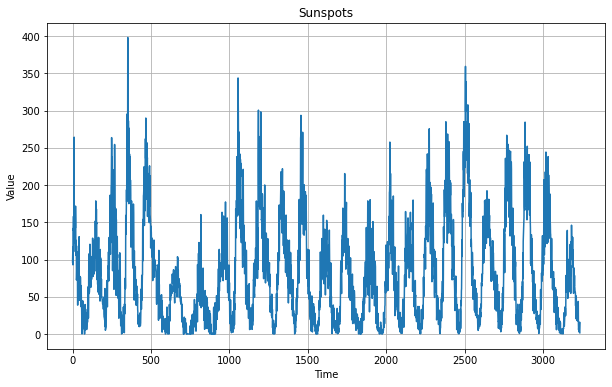

In [ ]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
title = "Sunspots"
plt.figure(figsize=(10, 6))
plot_series(time, series, title)


print(series.shape)
print(time.shape)

# Split Data

In [ ]:
split_time = 2500 # We have 10 years worth of data (3650) so the split time is more 75% 
time_train = time[:split_time] # 0..2500    => 2500
x_train = series[:split_time] 
time_valid = time[split_time:] # 2501..3650 => 1150
x_valid = series[split_time:]

window_size = 30 # 30 slices worth of data, so we're splitting the x_train 30 times !!!
batch_size = 32
shuffle_buffer_size = 1000

# Create a window

In [ ]:
# Window dataset, we're going to use it on x_train
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1) # This is required since we have specified a specific input function in the model
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

# Forecast function

In [ ]:
# We take the DNN model, and we try to apply it to our series use the window technique
# So after training it will help us forecast
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    # No map or shuffle, this was done in the windowed_dataset()
    forecast = model.predict(ds)
    return forecast

# RNN Model

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

# Simple RNN
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400.0)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history_rnn = model.fit(train_set, epochs=150)

Epoch 1/150
20/20 [==============================] - 1s 37ms/step - loss: 240.5033 - mae: 241.0029
Epoch 2/150
20/20 [==============================] - 1s 35ms/step - loss: 68.0092 - mae: 68.5077
Epoch 3/150
20/20 [==============================] - 1s 35ms/step - loss: 44.6689 - mae: 45.1663
Epoch 4/150
20/20 [==============================] - 1s 37ms/step - loss: 39.4873 - mae: 39.9841
Epoch 5/150
20/20 [==============================] - 1s 36ms/step - loss: 38.8776 - mae: 39.3745
Epoch 6/150
20/20 [==============================] - 1s 35ms/step - loss: 36.6283 - mae: 37.1247
Epoch 7/150
20/20 [==============================] - 1s 36ms/step - loss: 40.5958 - mae: 41.0929
Epoch 8/150
20/20 [==============================] - 1s 35ms/step - loss: 43.3995 - mae: 43.8970
Epoch 9/150
20/20 [==============================] - 1s 36ms/step - loss: 37.1928 - mae: 37.6896
Epoch 10/150
20/20 [==============================] - 1s 36ms/step - loss: 37.0684 - mae: 37.5653
Epoch 11/150
20/20 [=======

# RNN MAE and Loss

<Figure size 432x288 with 0 Axes>

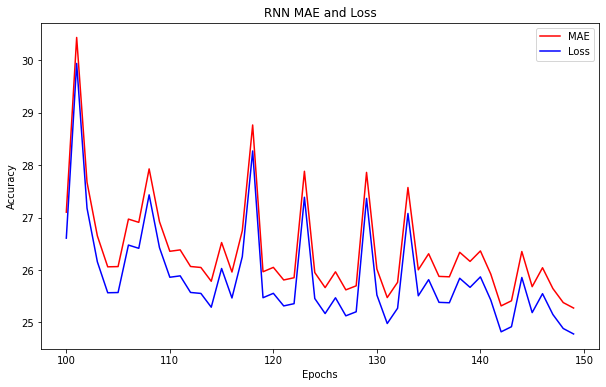

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history_rnn.history['mae']
loss=history_rnn.history['loss']

epochs=range(len(loss)) # Get number of epochs


epochs_zoom = epochs[100:150]
mae_zoom = mae[100:150]
loss_zoom = loss[100:150]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------

plt.figure(figsize=(10, 6))

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('RNN MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

# LSTM Model

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([

  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

# We have inferred from the previouss cell that the preferred Learning rate is 1e-5
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history_lstm = model.fit(train_set,epochs=150)

Epoch 1/150

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

25/25 [==============================] - 0s 14ms/step - loss: 56.1512 - mae: 56.6491
Epoch 2/150
25/25 [==============================] - 0s 14ms/step - loss: 30.6509 - mae: 31.1466
Epoch 3/150
25/25 [==============================] - 0s 15ms/step - loss: 23.5764 - mae: 24.0704
Epoch 4/150
25/25 [==============================] - 0s 18ms/step - loss: 20.7239 - mae: 21.2167
Epoch 5/150
25/25 [==============================] - 0s 13ms/step - loss: 19.9067 - mae: 20.3998
Epoch 6/150
25/25 [====

# LSTM MAE and Loss

<Figure size 432x288 with 0 Axes>

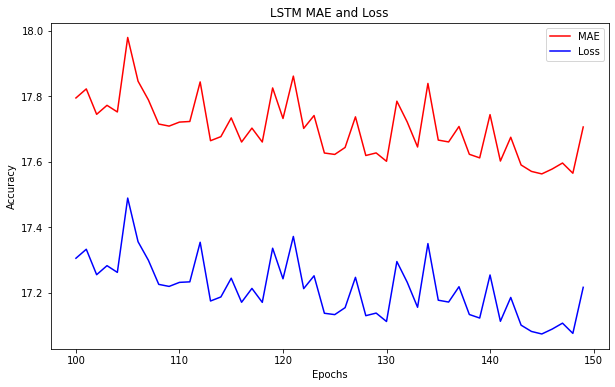

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history_lstm.history['mae']
loss=history_lstm.history['loss']

epochs=range(len(loss)) # Get number of epochs

epochs_zoom = epochs[100:150]
mae_zoom = mae[100:150]
loss_zoom = loss[100:150]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------

plt.figure(figsize=(10, 6))

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('LSTM MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

# BLSTM Model

In [ ]:
# https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session
# A common use-case for clear_session is releasing memory when building models and layers in a loop.
# Clears any internal variables, which means models will not impact later versions of themselves
tf.keras.backend.clear_session()

# This sets the graph-level seed.
# https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/random/set_seed
tf.random.set_seed(51)

# I's for operation level
np.random.seed(51)

# https://www.tensorflow.org/api_docs/python/tf/keras/backend/clear_session
# A common use-case for clear_session is releasing memory when building models and layers in a loop.
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Windowed BI-LSTM
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),# Given a tensor input, this operation inserts a dimension of size 1 at the dimension index axis of input's shape. 
                                                               # https://www.tensorflow.org/api_docs/python/tf/expand_dims
                      input_shape=[None]),     # This means that the model can take sequences of any length

  # The windowed_dataset() return two dimensional batches, with the first being the batch size and the second being the number of timesteps 
  # But the RNN expects three dimensions, so the lambda layer, help fix the difference in dimensions, by adding expannding the array by one dimension

  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),

  # input a sequence and don't output it, except for the last one (sequence to vector RNN), which is the default behavior of Keras TF, 
  # otherwise we set the return_sequence=False and we we'll have (sequence to sequence)

  # The output of the layer is three dimensionals [batch_size * number_units(nulber of units in a cell) * overall_steps(number of cells)]

  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400.0)

  # For example the activation function of the RNN use tanH functino which have values between -1 and 1, 
  # so we multipky the output by 100, so we can have the regular values of our input time series.
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), # Less sensitive to outliers
              optimizer=optimizer,
              metrics=["mae"])
history_blstm = model.fit(dataset, epochs=150)

Epoch 1/150
78/78 [==============================] - 1s 12ms/step - loss: 28.7541 - mae: 29.2497
Epoch 2/150
78/78 [==============================] - 1s 13ms/step - loss: 25.3496 - mae: 25.8447
Epoch 3/150
78/78 [==============================] - 1s 13ms/step - loss: 25.0914 - mae: 25.5862
Epoch 4/150
78/78 [==============================] - 1s 11ms/step - loss: 25.0713 - mae: 25.5661
Epoch 5/150
78/78 [==============================] - 1s 11ms/step - loss: 24.9099 - mae: 25.4046
Epoch 6/150
78/78 [==============================] - 1s 11ms/step - loss: 25.0104 - mae: 25.5050
Epoch 7/150
78/78 [==============================] - 1s 11ms/step - loss: 25.0213 - mae: 25.5158
Epoch 8/150
78/78 [==============================] - 1s 13ms/step - loss: 24.9505 - mae: 25.4453
Epoch 9/150
78/78 [==============================] - 1s 13ms/step - loss: 25.0404 - mae: 25.5350
Epoch 10/150
78/78 [==============================] - 1s 11ms/step - loss: 24.9379 - mae: 25.4325
Epoch 11/150
78/78 [=========

# BLSTM MAE & Loss

<Figure size 432x288 with 0 Axes>

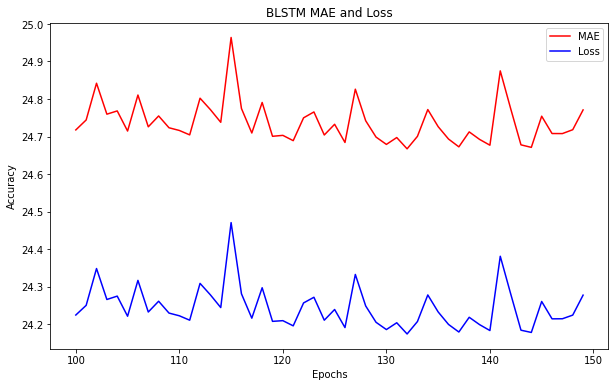

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history_blstm.history['mae']
loss=history_blstm.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------


epochs_zoom = epochs[100:150]
mae_zoom = mae[100:150]
loss_zoom = loss[100:150]


plt.figure(figsize=(10, 6))

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('BLSTM MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

# CNN LSTM Model

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size) # We take a window of x_train
print("train_set= ",train_set)
print("\n x_train.shape= ",x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]), # We have specified the input shape here so we need to change the windowed_dataset()
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history_cnn_lstm = model.fit(train_set, epochs=150)


train_set=  <PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>

 x_train.shape=  (2500,)
Epoch 1/150
10/10 [==============================] - 0s 30ms/step - loss: 46.9040 - mae: 47.4012
Epoch 2/150
10/10 [==============================] - 0s 29ms/step - loss: 29.1851 - mae: 29.6803
Epoch 3/150
10/10 [==============================] - 0s 24ms/step - loss: 25.4629 - mae: 25.9577
Epoch 4/150
10/10 [==============================] - 0s 25ms/step - loss: 23.5774 - mae: 24.0715
Epoch 5/150
10/10 [==============================] - 0s 25ms/step - loss: 22.0678 - mae: 22.5614
Epoch 6/150
10/10 [==============================] - 0s 28ms/step - loss: 21.3319 - mae: 21.8249
Epoch 7/150
10/10 [==============================] - 0s 27ms/step - loss: 20.7319 - mae: 21.2248
Epoch 8/150
10/10 [==============================] - 0s 36ms/step - loss: 20.2813 - mae: 20.7739
Epoch 9/150
10/10 [==============================] - 0s 28ms/step - loss: 19.9468 - mae: 20.

# CNN LSTM MAE & Loss

<Figure size 432x288 with 0 Axes>

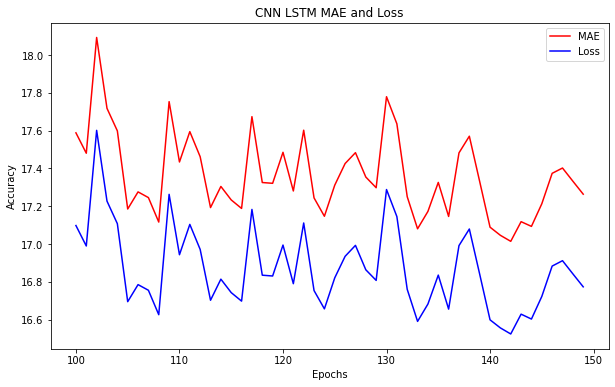

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history_cnn_lstm.history['mae']
loss=history_cnn_lstm.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------


epochs_zoom = epochs[100:150]
mae_zoom = mae[100:150]
loss_zoom = loss[100:150]


plt.figure(figsize=(10, 6))

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('CNN LSTM MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

# CNN BLSTM Model

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Windowed CNN BLSTM
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),    
  
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),



  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),

  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400.0)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=optimizer,
              metrics=["mae"])
history_cnn_blstm = model.fit(dataset, epochs=150)

Epoch 1/150
10/10 [==============================] - 0s 33ms/step - loss: 50.5476 - mae: 51.0455
Epoch 2/150
10/10 [==============================] - 0s 33ms/step - loss: 38.3857 - mae: 38.8825
Epoch 3/150
10/10 [==============================] - 0s 31ms/step - loss: 30.3458 - mae: 30.8415
Epoch 4/150
10/10 [==============================] - 0s 32ms/step - loss: 25.8489 - mae: 26.3432
Epoch 5/150
10/10 [==============================] - 0s 33ms/step - loss: 23.7556 - mae: 24.2500
Epoch 6/150
10/10 [==============================] - 0s 32ms/step - loss: 22.4358 - mae: 22.9293
Epoch 7/150
10/10 [==============================] - 0s 35ms/step - loss: 21.5135 - mae: 22.0069
Epoch 8/150
10/10 [==============================] - 0s 32ms/step - loss: 20.8320 - mae: 21.3248
Epoch 9/150
10/10 [==============================] - 0s 30ms/step - loss: 20.3829 - mae: 20.8756
Epoch 10/150
10/10 [==============================] - 0s 33ms/step - loss: 20.0733 - mae: 20.5661
Epoch 11/150
10/10 [=========

# CNN BLSTM MAE and Loss

<Figure size 432x288 with 0 Axes>

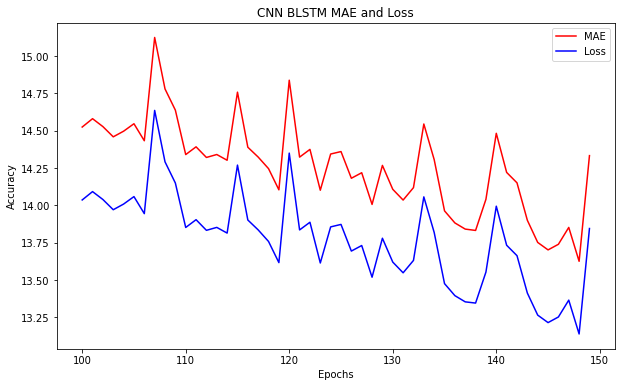

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history_cnn_blstm.history['mae']
loss=history_cnn_blstm.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------


epochs_zoom = epochs[100:150]
mae_zoom = mae[100:150]
loss_zoom = loss[100:150]


plt.figure(figsize=(10, 6))

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('CNN BLSTM MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()